In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [47]:
# Função para codificar variáveis e padronizar dados
def preprocess_data(df, categorical_vars):
    y = df['STROKE']
    X = df.drop(columns=['STROKE'])
    
    # Codificar variáveis categóricas
    X_encoded = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
    
    # Padronizar variáveis numéricas
    numerical_vars = X_encoded.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X_encoded[numerical_vars] = scaler.fit_transform(X_encoded[numerical_vars])
    
    return X_encoded, y

# Função para criar gráfico de barras horizontais
def plot_top_features(coef_df, top_n=5):
    top_features = coef_df.nlargest(top_n, 'Coefficient')
    
    plt.figure(figsize=(10, 8))
    plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coeficiente', fontsize=14)
    plt.ylabel('Variável', fontsize=14)
    plt.title(f'Top {top_n} Variáveis com Maior Coeficiente', fontsize=16)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Função para plotar curva ROC
def plot_roc_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    else:
        raise ValueError(f"O modelo {model_name} não suporta previsão de probabilidade.")
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.fill_between(fpr, tpr, alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14)
    plt.title(f'Curva ROC - {model_name}', fontsize=16)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [48]:
df=pd.read_csv('dados_agregados_limpos.csv')

pd.set_option('display.max_rows', None)


#Limpando variáveis para utilizar os modelos de predição

df.drop(['SLEEP_TIME', 'Unnamed: 0'], axis=1, inplace=True)


vars_to_clean_1 = [
    'SMOKE', 'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
    'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
    'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
    'CORONARY_DISEASE', 'HEART_ATTACK', 'STROKE', 'THYROID_PROBLEMA', 
    'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
    'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
]

# Lista das variáveis para a segunda limpeza (remover 77, 99)
vars_to_clean_2 = ['ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY']

# Remover linhas com valores 9, 7, 77 nas primeiras variáveis
df = df[~df[vars_to_clean_1].isin([9, 7, 77]).any(axis=1)]

# Remover linhas com valores 77, 99 nas segundas variáveis
df = df[~df[vars_to_clean_2].isin([77, 99]).any(axis=1)]

#Deixando as variáveis alvo com respostas binárias para a ocorrência ou não do evento
targets = ['DIABETES', 'STROKE', 'HEART_ATTACK', 'HIGH_PRESSURE']

df[targets] = df[targets].applymap(lambda x: 1 if x == 1 else 0)

Treinando Logistic Regression...
Acurácia do Logistic Regression: 0.96


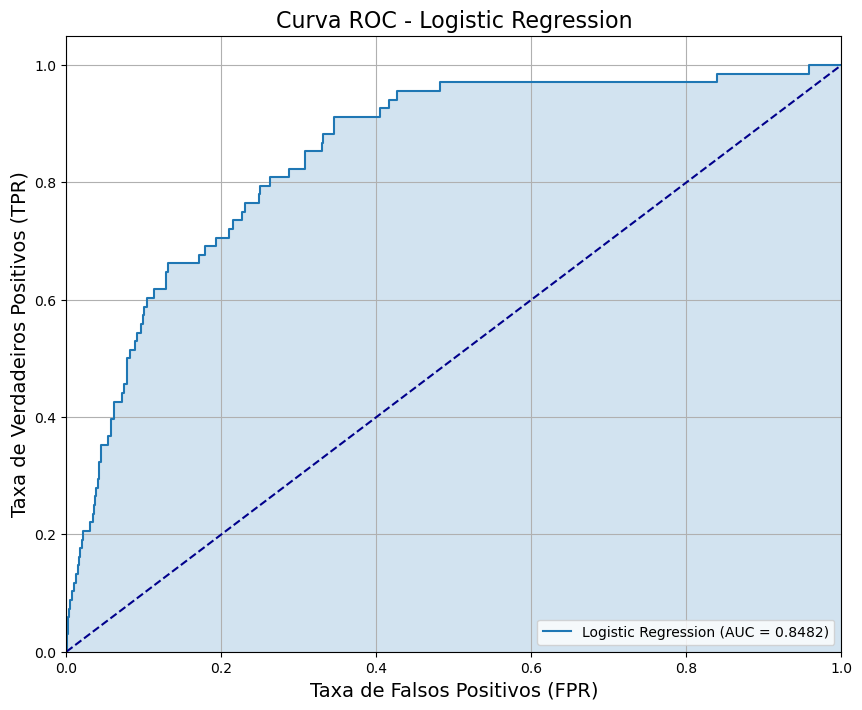

Treinando Decision Tree...
Acurácia do Decision Tree: 0.92


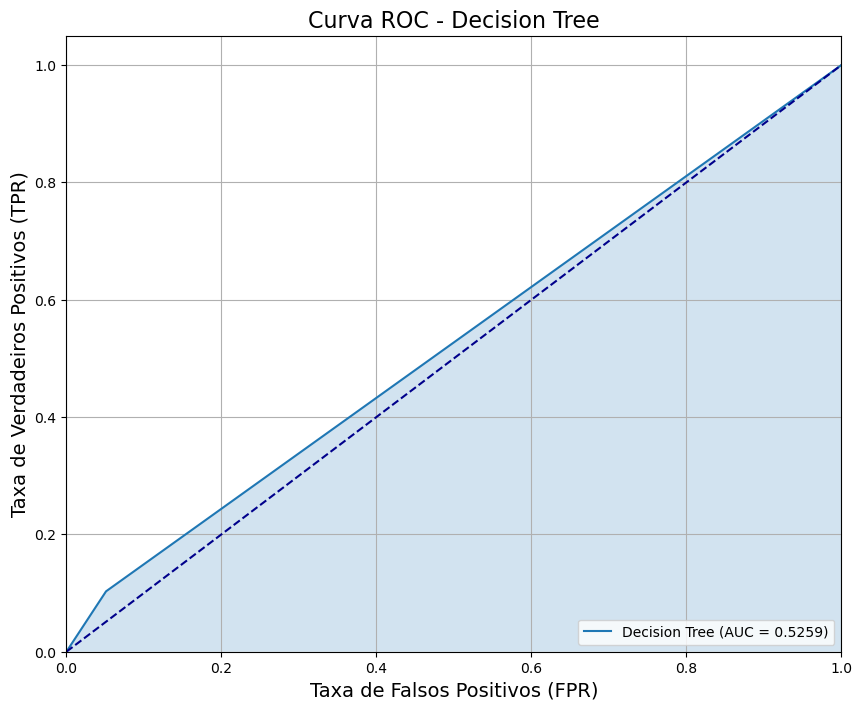

Treinando Random Forest...
Acurácia do Random Forest: 0.96


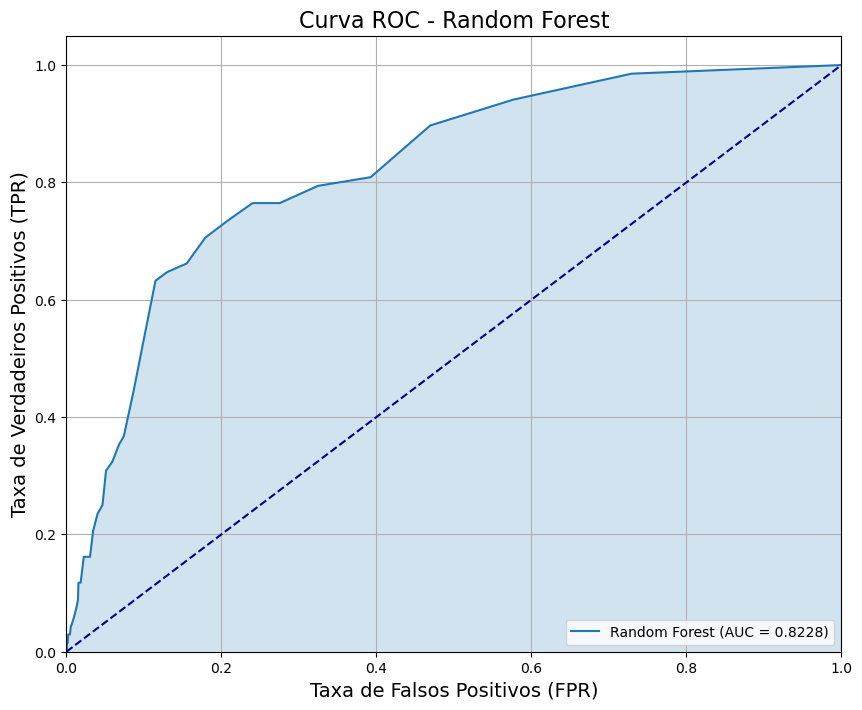

Treinando SVM...
Acurácia do SVM: 0.96


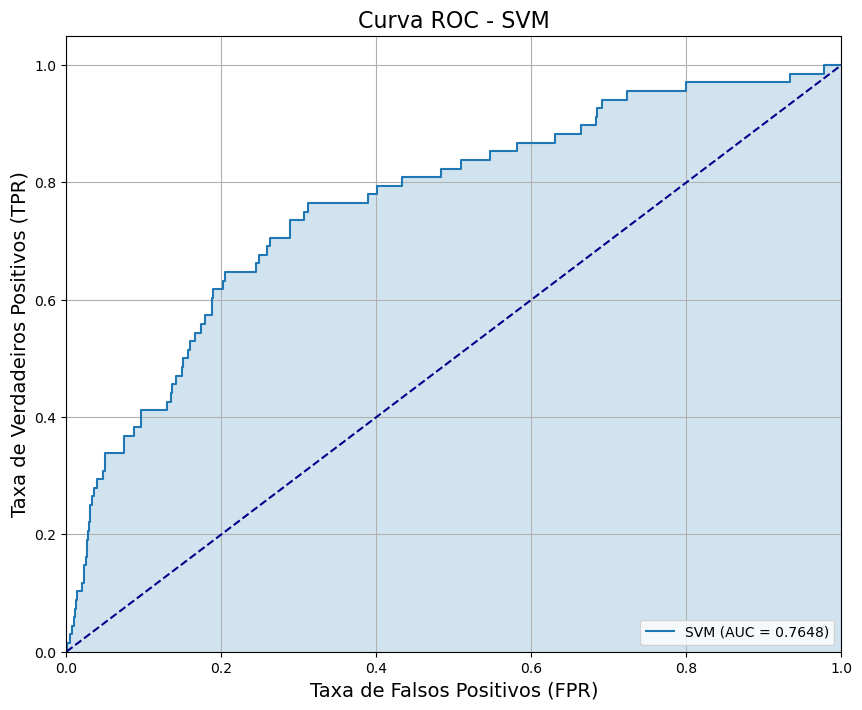

Treinando XGBoost...
Acurácia do XGBoost: 0.96


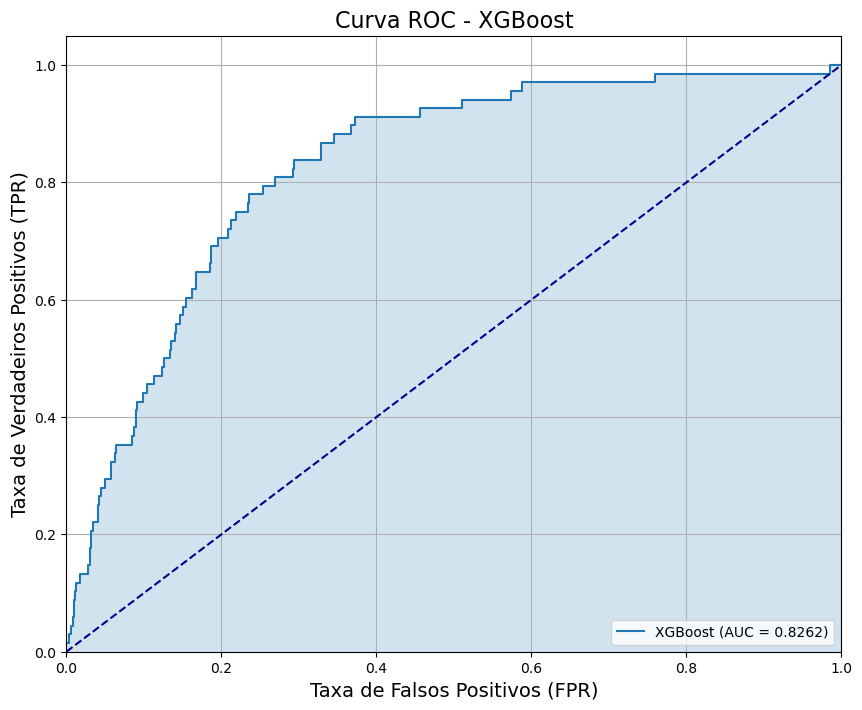

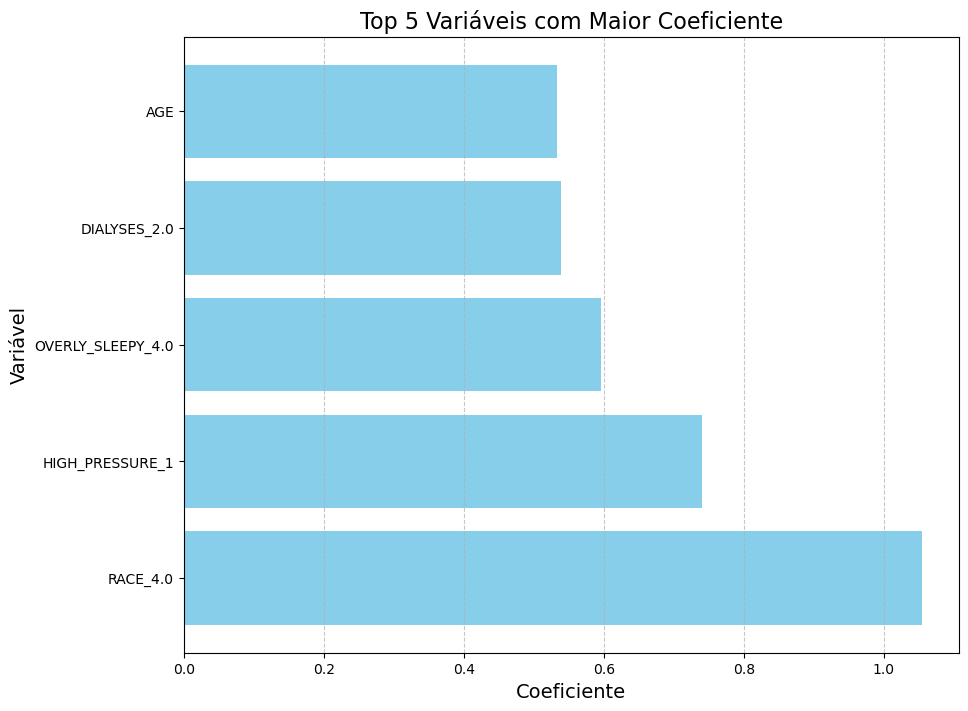

In [49]:
# Definir variáveis categóricas
categorical_vars = [
    'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
    'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
    'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
    'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
    'CORONARY_DISEASE', 'HEART_ATTACK', 'DIABETES', 'THYROID_PROBLEMA', 
    'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
    'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
]

# Processar dados
X_encoded, y = preprocess_data(df, categorical_vars)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Modelos a serem testados
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),  # SVM precisa de probability=True para usar predict_proba
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

# Treinar, prever e avaliar modelos
for model_name, model in models.items():
    print(f"Treinando {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia do {model_name}: {accuracy:.2f}")
    
    # Plotar curva ROC
    plot_roc_curve(model, X_test, y_test, model_name)

# Extração dos coeficientes do modelo de Regressão Logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
coefficients = log_reg.coef_[0]
features = X_encoded.columns

# Criar DataFrame com variáveis e coeficientes
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Plotar as 5 variáveis com maior coeficiente
plot_top_features(coef_df, top_n=5)

In [38]:
# Repetindo o modelo de Regressão Logística
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Prever os resultados no conjunto de teste
y_pred = model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")

# Obter os coeficientes do modelo
coef = model.coef_[0]
features = X_encoded.columns

# Criar um DataFrame para visualizar os coeficientes
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef
}).sort_values(by='Coefficient', ascending=False)


importance_df

Acurácia do modelo: 0.96


,Feature,Coefficient
33,RACE_4.0,1.054707
41,HIGH_PRESSURE_1,0.740998
67,OVERLY_SLEEPY_4.0,0.596402
29,DIALYSES_2.0,0.538338
4,AGE,0.532477
9,WAIST,0.415082
19,ALCOHOL_FREQUENCY_7.0,0.393208
48,HEART_ATTACK_1,0.389297
36,EDUCATION_3.0,0.389098
6,WEIGHT,0.386891


In [39]:


recall = recall_score(y_test, y_pred, pos_label=1)  # `pos_label` é a classe positiva, ajuste se necessário
print(f"Recall do modelo: {recall:.2f}")

Recall do modelo: 0.07


In [40]:


# Calcular precisão e recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Calcular F1 Score
f1 = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.13


In [41]:
X_train = X_train.astype(int)


In [42]:
# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Repetir o treinamento do modelo com dados balanceados
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_sm, y_train_sm)

# Prever os resultados no conjunto de teste
y_pred = model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo com SMOTE: {accuracy:.2f}")

# Obter os coeficientes do modelo
coef = model.coef_[0]
features = X_encoded.columns


y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


# Avaliar o modelo
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC', roc_auc)


Acurácia do modelo com SMOTE: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1740
           1       0.13      0.25      0.17        68

    accuracy                           0.91      1808
   macro avg       0.55      0.59      0.56      1808
weighted avg       0.94      0.91      0.92      1808

Confusion Matrix:
 [[1625  115]
 [  51   17]]
ROC AUC 0.7417173766058147


In [52]:


# Calcular precisão, recall e limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Encontrar o limiar que equilibra a precisão e o recall
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Optimal Threshold for Balanced Precision and Recall: {best_threshold:.2f}')

# Fazer previsões binárias com o limiar ajustado
y_pred_adjusted = (y_pred_prob > best_threshold).astype(int)

# Avaliar o desempenho do modelo
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)

accuracy = accuracy_score(y_test, y_pred_adjusted)
print(f"Acurácia do modelo: {accuracy:.2f}")
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Adjusted F1-score: {f1:.2f}')
print(f'Adjusted Recall: {recall:.2f}')
print(f'Adjusted Precision: {precision_adjusted:.2f}')

print('Confusion Matrix (Adjusted Threshold):\n', confusion_matrix(y_test, y_pred_adjusted))
print('Classification Report:\n', classification_report(y_test, y_pred_adjusted))

Optimal Threshold for Balanced Precision and Recall: 0.25
Acurácia do modelo: 0.86
ROC AUC: 0.74
Adjusted F1-score: 0.21
Adjusted Recall: 0.50
Adjusted Precision: 0.13
Confusion Matrix (Adjusted Threshold):
 [[1517  223]
 [  34   34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      1740
           1       0.13      0.50      0.21        68

    accuracy                           0.86      1808
   macro avg       0.56      0.69      0.57      1808
weighted avg       0.95      0.86      0.90      1808

